<a href="https://colab.research.google.com/github/gabrie1-s/WQA_Regression_HW2/blob/main/Teste_outiliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from matplotlib import pyplot as plt
import scipy as scipy
import plotly.express as px
from matplotlib.backends.backend_pdf import PdfPages
import math
from scipy import stats
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
drive.mount('/content/drive')

w_wine = pd.read_csv('drive/My Drive/ICA/winequality-white.csv', sep = ';')
r_wine = pd.read_csv('drive/My Drive/ICA/winequality-red.csv', sep = ';')

Mounted at /content/drive


#Considerações iniciais sobre as variáveis

In [ ]:
w_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [ ]:
r_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


#1. Vinho Branco - Teste com outliers

##1.1 Preprocessamento

In [ ]:
w_wine_raw = w_wine.copy()

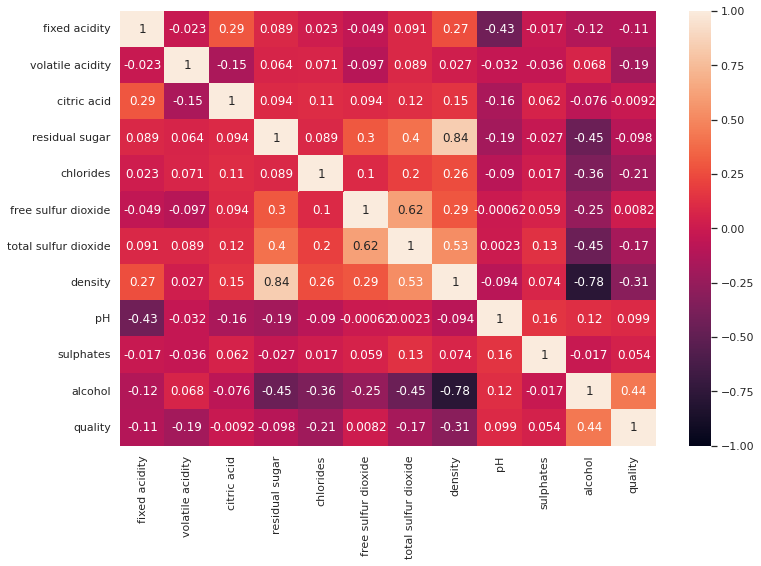

In [ ]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.heatmap(w_wine_raw.corr(), annot=True, vmin=-1, vmax=1)
plt.savefig('w_wine_heatmap.png')

In [ ]:
X = w_wine_raw.iloc[:, 0:11]
y = w_wine_raw.iloc[:, -1]
column_name = w_wine_raw.drop(columns=['quality']).columns

# In general, it's a good idea to scale the data prior to PCA.
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    
pca = PCA()
x_new = pca.fit_transform(X)

def myplot(pcs,loadings, target, column_name, labels=None):
    xs = pcs[:,0]
    ys = pcs[:,1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    pc1 = xs*scalex
    pc2 = ys*scaley

    df = {'pc1': pc1, 'pc2': pc2, 'quality': target}
    df = pd.DataFrame(data=df)

    fig = px.scatter(df, x='pc1', y='pc2', color='quality', color_continuous_scale = "rainbow")

    for i, feature in enumerate(column_name):
        fig.add_shape(type='line',
                      x0=0,
                      y0=0,
                      x1=loadings[i,0],
                      y1=loadings[i,1]
                    )
        fig.add_annotation(x=loadings[i,0],
                           y=loadings[i,1],
                           ax=0,
                           ay=0,
                           xanchor="center",
                           yanchor="bottom",
                           text = feature,
                           font=dict(size=18,
                                     color="crimson"
                                    )
                          )
    fig.show()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]), y, column_name)

Para evitar problemas de multicolinearidade, precisamos eliminar preditores que são muito correlacionados. Consideraremos como relevante correlações maiores que 0.6 em valor absoluto. Com base na PCA, removeremos o preditor com menores loadings em cada correlação.



In [ ]:
w_wine_raw.drop(columns=["free sulfur dioxide", "density"], inplace = True)

##1.2 Teste com modelos de regressão

### 1.2.1 Regressão Linear

**Importando bibliotecas**

In [ ]:
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn as sk

**Definindo o x e y**

In [ ]:
df = pd.DataFrame.from_dict(w_wine_raw)
w_wine_train = df.copy(deep=False)
del w_wine_train['quality']
y = pd.concat([w_wine_raw['quality']], axis = 1)

**Fazendo a regressão linear**

In [ ]:
x_treino, x_teste, y_treino, y_teste = skms.train_test_split(w_wine_train, y, test_size=0.25, random_state=0)
lm = sklm.LinearRegression()
lm.fit(x_treino, y_treino)
f = lm.predict(w_wine_train)
y_pred = lm.predict(x_teste)

In [ ]:
print(lm.coef_)
print(lm.intercept_)

[[-5.46339803e-02 -2.05357991e+00 -3.52302204e-02  2.75536890e-02
  -1.27237931e+00  4.54969942e-04  1.84288713e-01  3.45961686e-01
   3.67296060e-01]]
[2.05341927]


#### Cross-validation - Vinho Branco

**RMSE 5-fold Cross validation**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits = 5, random_state = None)
media = cross_val_score(lm, w_wine_train, y, cv=kf, scoring = 'neg_mean_squared_error')
print(-media)

[0.71563668 0.60041333 0.58425216 0.54840913 0.50676144]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

-0.5910945457809145
-------------
0.07011207981119108


**RMSE 10-fold Cross validation**

In [ ]:
kf = KFold(n_splits = 10, random_state = None)
media = cross_val_score(lm, w_wine_train, y, cv=kf, scoring = 'neg_mean_squared_error')
print(-media)

[0.63332502 0.77285728 0.68274964 0.50639172 0.63171875 0.52974795
 0.58011463 0.51202105 0.55654817 0.42772572]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

-0.5833199939469293
-------------
0.0945841556455962


**$R^2$ 5-Fold validation**

In [ ]:
kf = KFold(n_splits = 5, random_state = None)
media = cross_val_score(lm, w_wine_train, y, cv=kf, scoring = 'r2')
print(media)

[0.17950306 0.28265066 0.26116092 0.29886591 0.15626237]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

0.23568858542916118
-------------
0.05711564894924685


**$R^2$ 10-Fold validation**

In [ ]:
kf = KFold(n_splits = 10, random_state = None)
media = cross_val_score(lm, w_wine_train, y, cv=kf, scoring = 'r2')
print(media)

[0.19561715 0.18520146 0.25390874 0.32559377 0.14290581 0.33988051
 0.25348496 0.34662591 0.17419143 0.18830689]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

0.24057166431223515
-------------
0.07102567664386267


### 1.2.2 Regressão $L_2$-penalizada/Ridge

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# dividindo os dados entre conjunto de teste e treino
# definindo o cojunto de dados X para a regressão
df = pd.DataFrame.from_dict(w_wine_raw)
w_wine_train = df.copy(deep=False)
del w_wine_train['quality']
y = pd.concat([w_wine_raw['quality']], axis = 1) # definindo a variável independente

x_treino, x_teste, y_treino, y_teste = skms.train_test_split(w_wine_train, y, test_size=0.25, random_state=0)

# centralizando e scaling dos dados
x_treino = StandardScaler().fit_transform(x_treino)
x_teste = StandardScaler().fit_transform(x_teste)

# definindo espaço de busca para os lambdas
lambdas = np.linspace(5, 21, 1000)

In [ ]:
scores_RMSE = []
scores_R2 = []

for lamb in lambdas:
    # aplicando a regressão
    ridge = sklm.Ridge(alpha = lamb)
    ridge.fit(x_treino, y_treino)             # Fit a ridge regression on the training data
    
    scores = skms.cross_validate(ridge, x_treino, y_treino, cv=10, scoring=('r2', 'neg_root_mean_squared_error'))
    
    scores_RMSE.append(np.mean(scores['test_neg_root_mean_squared_error']*(-1)))
    scores_R2.append(np.mean(scores['test_r2']))

In [ ]:
ridge_best_w = sklm.Ridge(alpha = 0.25)
ridge_best_w.fit(x_treino, y_treino)             # Fit a ridge regression on the training data
pred_w = ridge_best_w.predict(x_teste)           # Use this model to predict the test data
print("RMSE :\n", mean_squared_error(y_teste, pred_w, squared=False))          # Calculate the test MSE
print("R2 :\n", r2_score(y_teste, pred_w))          # Calculate the test R2

RMSE :
 0.7941812955827101
R2 :
 0.24640304324490891


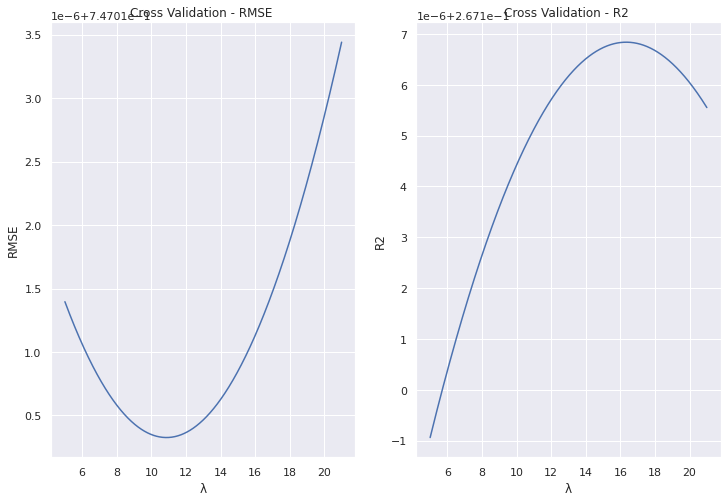

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(lambdas, scores_RMSE, label = 'RMSE')
ax[0].set_title("Cross Validation - RMSE ")
ax[0].set_xlabel('$\mathregular{\lambda}$')
ax[0].set_ylabel('RMSE')

ax[1].plot(lambdas, scores_R2, label = '$\mathregular{R^2}$')
ax[1].set_title("Cross Validation - R2 ")
ax[1].set_xlabel('$\mathregular{\lambda}$')
ax[1].set_ylabel('R2')
plt.show()

In [ ]:
print("RMSE:", min(scores_RMSE),"    R2:", max(scores_R2))

RMSE: 0.7470103263877588     R2: 0.26710683682865544


In [ ]:
print("RMSE:", np.std(scores_RMSE),"    R2:", np.std(scores_R2))

RMSE: 8.336842929545951e-07     R2: 2.1942886326623905e-06


#2. Vinho Branco - Teste sem outliers

In [ ]:
def plot_boxplot(df, ft):
  df.boxplot(column = [ft])
  plt.grid(False)
  plt.show()

def outliers(df, ft):
  Q1 = df[ft].quantile(0.25)
  Q3 = df[ft].quantile(0.75)
  I = Q3 - Q1
  LwLimit = Q1 - 1.5*I
  UpLimit = Q3 + 1.5*I
  ls = df.index[(df[ft] < LwLimit) | (df[ft] > UpLimit)]
  return ls

def remove(df, ls):
  ls = sorted(set(ls))
  df = df.drop(ls)
  return df

def apply_remotion(dataset):
  remover = []
  for i in dataset:
      if(i!='quality'):
          remover.extend(outliers(dataset, i))
  dataset_cleaned = remove(dataset, remover)
  return dataset_cleaned 

In [ ]:
w_wine_cleaned = apply_remotion(w_wine)

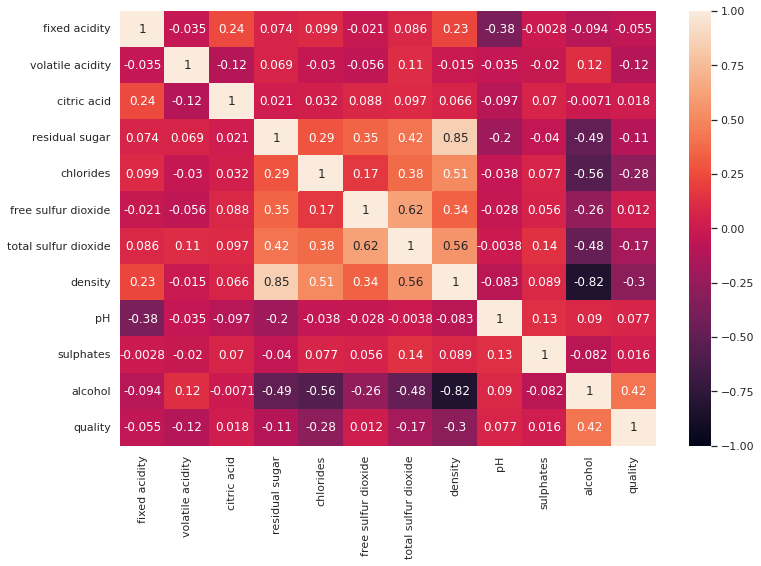

In [ ]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.heatmap(w_wine_cleaned.corr(), annot=True, vmin=-1, vmax=1)
plt.savefig('w_wine_heatmap.png')

In [ ]:
X = w_wine_cleaned.iloc[:, 0:11]
y = w_wine_cleaned.iloc[:, -1]
column_name = w_wine_cleaned.drop(columns=['quality']).columns

# In general, it's a good idea to scale the data prior to PCA.
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    
pca = PCA()
x_new = pca.fit_transform(X)

def myplot(pcs,loadings, target, column_name, labels=None):
    xs = pcs[:,0]
    ys = pcs[:,1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    pc1 = xs*scalex
    pc2 = ys*scaley

    df = {'pc1': pc1, 'pc2': pc2, 'quality': target}
    df = pd.DataFrame(data=df)

    fig = px.scatter(df, x='pc1', y='pc2', color='quality', color_continuous_scale = "rainbow")

    for i, feature in enumerate(column_name):
        fig.add_shape(type='line',
                      x0=0,
                      y0=0,
                      x1=loadings[i,0],
                      y1=loadings[i,1]
                    )
        fig.add_annotation(x=loadings[i,0],
                           y=loadings[i,1],
                           ax=0,
                           ay=0,
                           xanchor="center",
                           yanchor="bottom",
                           text = feature,
                           font=dict(size=18,
                                     color="crimson"
                                    )
                          )
    fig.show()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]), y, column_name)

Para evitar problemas de multicolinearidade, precisamos eliminar preditores que são muito correlacionados. Consideraremos como relevante correlações maiores que 0.6 em valor absoluto. Com base na PCA, removeremos o preditor com menores loadings em cada correlação.



In [ ]:
w_wine_cleaned.drop(columns=["free sulfur dioxide", "density"], inplace = True)

##2.2 Teste com modelos de regressão

### 2.2.1 Regressão Linear

**Importando bibliotecas**

In [ ]:
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn as sk

**Definindo o x e y**

In [ ]:
df = pd.DataFrame.from_dict(w_wine_cleaned)
w_wine_train = df.copy(deep=False)
del w_wine_train['quality']
y = pd.concat([w_wine_cleaned['quality']], axis = 1)

**Fazendo a regressão linear**

In [ ]:
x_treino, x_teste, y_treino, y_teste = skms.train_test_split(w_wine_train, y, test_size=0.25, random_state=0)
lm = sklm.LinearRegression()
lm.fit(x_treino, y_treino)
f = lm.predict(w_wine_train)
y_pred = lm.predict(x_teste)

In [ ]:
print(lm.coef_)
print(lm.intercept_)

[[-3.53269660e-03 -2.09370263e+00 -1.07081269e-01  2.87595090e-02
  -6.08088145e+00  8.19359686e-04  2.90255887e-01  5.50950695e-01
   3.67897391e-01]]
[1.44372636]


#### Cross-validation - Vinho Branco

**RMSE 5-fold Cross validation**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits = 5, random_state = None)
media = cross_val_score(lm, w_wine_train, y, cv=kf, scoring = 'neg_mean_squared_error')
print(-media)

[0.68011449 0.62540292 0.57208233 0.51430625 0.49946227]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

-0.5782736525023674
-------------
0.06772609295510632


**RMSE 10-fold Cross validation**

In [ ]:
kf = KFold(n_splits = 10, random_state = None)
media = cross_val_score(lm, w_wine_train, y, cv=kf, scoring = 'neg_mean_squared_error')
print(-media)

[0.58242499 0.75131494 0.65739339 0.58198181 0.57946858 0.55650255
 0.56669664 0.46304108 0.57084645 0.3980578 ]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

-0.5707728207078235
-------------
0.09060490061939849


**$R^2$ 5-Fold validation**

In [ ]:
kf = KFold(n_splits = 5, random_state = None)
media = cross_val_score(lm, w_wine_train, y, cv=kf, scoring = 'r2')
print(media)

[0.14215529 0.21639126 0.25034885 0.28685246 0.11543976]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

0.20223752342534773
-------------
0.06452664888648975


**$R^2$ 10-Fold validation**

In [ ]:
kf = KFold(n_splits = 10, random_state = None)
media = cross_val_score(lm, w_wine_train, y, cv=kf, scoring = 'r2')
print(media)

[0.16439802 0.14434062 0.21156702 0.22102927 0.1905222  0.24527557
 0.24617496 0.31845464 0.15684425 0.11272399]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

0.20113305343646704
-------------
0.0571939780699425


### 2.2.2 Regressão $L_2$-penalizada/Ridge

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# dividindo os dados entre conjunto de teste e treino
# definindo o cojunto de dados X para a regressão
df = pd.DataFrame.from_dict(w_wine_cleaned)
w_wine_train = df.copy(deep=False)
del w_wine_train['quality']
y = pd.concat([w_wine_cleaned['quality']], axis = 1) # definindo a variável independente

x_treino, x_teste, y_treino, y_teste = skms.train_test_split(w_wine_train, y, test_size=0.25, random_state=0)

# centralizando e scaling dos dados
x_treino = StandardScaler().fit_transform(x_treino)
x_teste = StandardScaler().fit_transform(x_teste)

# definindo espaço de busca para os lambdas
lambdas = np.linspace(5, 21, 1000)

In [ ]:
scores_RMSE = []
scores_R2 = []

for lamb in lambdas:
    # aplicando a regressão
    ridge = sklm.Ridge(alpha = lamb)
    ridge.fit(x_treino, y_treino)             # Fit a ridge regression on the training data
    
    scores = skms.cross_validate(ridge, x_treino, y_treino, cv=10, scoring=('r2', 'neg_root_mean_squared_error'))
    
    scores_RMSE.append(np.mean(scores['test_neg_root_mean_squared_error']*(-1)))
    scores_R2.append(np.mean(scores['test_r2']))

In [ ]:
ridge_best_w = sklm.Ridge(alpha = 0.25)
ridge_best_w.fit(x_treino, y_treino)             # Fit a ridge regression on the training data
pred_w = ridge_best_w.predict(x_teste)           # Use this model to predict the test data
print("RMSE :\n", mean_squared_error(y_teste, pred_w, squared=False))          # Calculate the test MSE
print("R2 :\n", r2_score(y_teste, pred_w))          # Calculate the test R2

RMSE :
 0.7295747038673819
R2 :
 0.21340829775134718


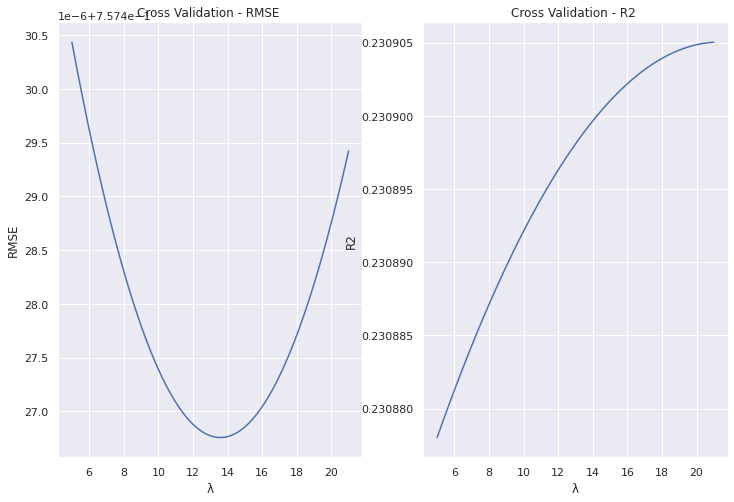

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(lambdas, scores_RMSE, label = 'RMSE')
ax[0].set_title("Cross Validation - RMSE ")
ax[0].set_xlabel('$\mathregular{\lambda}$')
ax[0].set_ylabel('RMSE')

ax[1].plot(lambdas, scores_R2, label = '$\mathregular{R^2}$')
ax[1].set_title("Cross Validation - R2 ")
ax[1].set_xlabel('$\mathregular{\lambda}$')
ax[1].set_ylabel('R2')
plt.show()

In [ ]:
print("RMSE:", min(scores_RMSE),"    R2:", max(scores_R2))

RMSE: 0.7574267563253492     R2: 0.230905031243379


In [ ]:
print("RMSE:", np.std(scores_RMSE),"    R2:", np.std(scores_R2))

RMSE: 9.838474032008564e-07     R2: 8.021827522618924e-06


# Vinho branco - Comparação

<table>
  <thead>
    <tr>
      <th scope="col">Método</th>
      <th scope="col" colspan="2">Com outliers</th>
      <th scope="col" colspan="2">Sem outliers</th>
      <th scope="col">Direrença entre médias
    </tr>
  </thead>
  <tbody>
    <tr>
      <th scope="row">#</th>
      <td><strong>Média</strong></td>
      <td><strong>Desvio Padrão</strong></td>
      <td><strong>Média</strong></td>
      <td><strong>Desvio Padrão<strong></td>
      <td><strong>#<strong></td>
    </tr>
    <tr>
      <th scope="row">Regressão Linear (RMSE 5-Fold)</th>
      <td>0.591</td>
      <td>0.070</td>
      <td>0.578</td>
      <td>0.068</td>
      <td>-2.2%</td>
    </tr>
    <tr>
      <th scope="row">Regressão Linear (RMSE 10-Fold)</th>
      <td>0.583</td>
      <td>0.095</td>
      <td>0.570</td>
      <td>0.090</td>
      <td>-2.2%</td>
    </tr>
    <tr>
      <th scope="row">Regressão Linear (R2 5-Fold)</th>
      <td>0.236</td>
      <td>0.057</td>
      <td>0.202</td>
      <td>0.065</td>
      <td>-16.8%</td>
    </tr>
    <tr>
      <th scope="row">Regressão Linear (R2 10-Fold)</th>
      <td>0.241</td>
      <td>0.071</td>
      <td>0.201</td>
      <td>0.057</td>
      <td>-19.9%</td>
    </tr>
    <tr>
      <th scope="row">Regressão L2 (RMSE)</th>
      <td>0.747</td>
      <td>0</td>
      <td>0.757</td>
      <td>0</td>
      <td>1.3%</td>
    </tr>
    <tr>
      <th scope="row">Regressão L2 (R2)</th>
      <td>0.267</td>
      <td>0</td>
      <td>0.231</td>
      <td>0</td>
      <td>-15.6%</td>
    </tr>
    
  </tbody>
</table>

#3 Vinho tinto - Teste com outliers

## 3.1 Preprocessamento

In [ ]:
r_wine_raw = r_wine.copy()

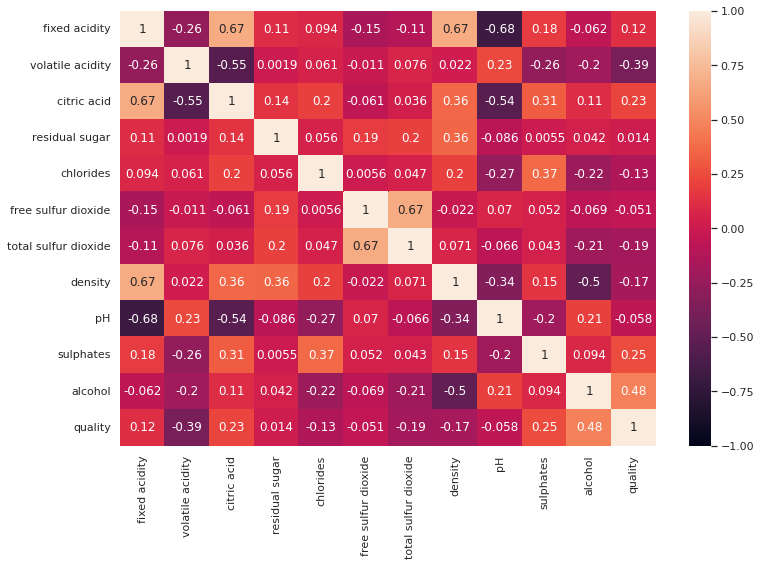

In [ ]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.heatmap(r_wine_raw.corr(), annot=True, vmin=-1, vmax=1)
plt.savefig('r_wine_heatmap.png')

In [ ]:
X = r_wine_raw.iloc[:, 0:11]
y = r_wine_raw.iloc[:, -1]
column_name = r_wine_raw.drop(columns=['quality']).columns

# In general, it's a good idea to scale the data prior to PCA.
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    
pca = PCA()
x_new = pca.fit_transform(X)

def myplot(pcs,loadings, target, column_name, labels=None):
    xs = pcs[:,0]
    ys = pcs[:,1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    pc1 = xs*scalex
    pc2 = ys*scaley

    df = {'pc1': pc1, 'pc2': pc2, 'quality': target}
    df = pd.DataFrame(data=df)

    fig = px.scatter(df, x='pc1', y='pc2', color='quality', color_continuous_scale = "rainbow")

    for i, feature in enumerate(column_name):
        fig.add_shape(type='line',
                      x0=0,
                      y0=0,
                      x1=loadings[i,0],
                      y1=loadings[i,1]
                    )
        fig.add_annotation(x=loadings[i,0],
                           y=loadings[i,1],
                           ax=0,
                           ay=0,
                           xanchor="center",
                           yanchor="bottom",
                           text = feature,
                           font=dict(size=18,
                                     color="crimson"
                                    )
                          )
    fig.show()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]), y, column_name)

In [ ]:
r_wine_raw.drop(columns=["free sulfur dioxide", "citric acid", "density", "fixed acidity"], inplace = True)

In [ ]:
def plot_boxplot(df, ft):
  df.boxplot(column = [ft])
  plt.grid(False)
  plt.show()
def outliers(df, ft):
  Q1 = df[ft].quantile(0.25)
  Q3 = df[ft].quantile(0.75)
  I = Q3 - Q1
  LwLimit = Q1 - 1.5*I
  UpLimit = Q3 + 1.5*I
  ls = df.index[(df[ft] < LwLimit) | (df[ft] > UpLimit)]
  return ls
def remove(df, ls):
  ls = sorted(set(ls))
  df = df.drop(ls)
  return df
def apply_remotion(dataset):
  remover = []
  for i in dataset:
      if(i!='quality'):
          remover.extend(outliers(dataset, i))
  dataset_cleaned = remove(dataset, remover)
  return dataset_cleaned 

In [ ]:
w_wine_cleaned = apply_remotion(w_wine)

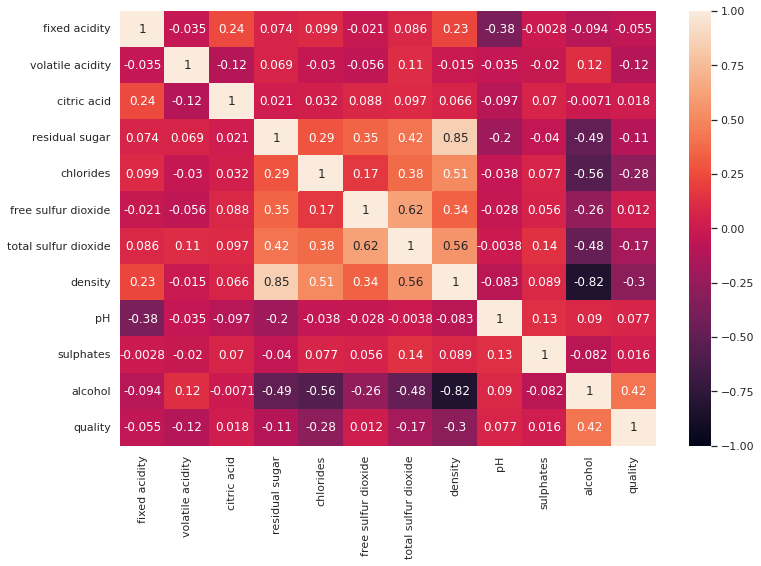

In [ ]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.heatmap(w_wine_cleaned.corr(), annot=True, vmin=-1, vmax=1)
plt.savefig('w_wine_heatmap.png')

In [ ]:
X = w_wine_cleaned.iloc[:, 0:11]
y = w_wine_cleaned.iloc[:, -1]
column_name = w_wine_cleaned.drop(columns=['quality']).columns

# In general, it's a good idea to scale the data prior to PCA.
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    
pca = PCA()
x_new = pca.fit_transform(X)

def myplot(pcs,loadings, target, column_name, labels=None):
    xs = pcs[:,0]
    ys = pcs[:,1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    pc1 = xs*scalex
    pc2 = ys*scaley

    df = {'pc1': pc1, 'pc2': pc2, 'quality': target}
    df = pd.DataFrame(data=df)

    fig = px.scatter(df, x='pc1', y='pc2', color='quality', color_continuous_scale = "rainbow")

    for i, feature in enumerate(column_name):
        fig.add_shape(type='line',
                      x0=0,
                      y0=0,
                      x1=loadings[i,0],
                      y1=loadings[i,1]
                    )
        fig.add_annotation(x=loadings[i,0],
                           y=loadings[i,1],
                           ax=0,
                           ay=0,
                           xanchor="center",
                           yanchor="bottom",
                           text = feature,
                           font=dict(size=18,
                                     color="crimson"
                                    )
                          )
    fig.show()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]), y, column_name)

Para evitar problemas de multicolinearidade, precisamos eliminar preditores que são muito correlacionados. Consideraremos como relevante correlações maiores que 0.6 em valor absoluto. Com base na PCA, removeremos o preditor com menores loadings em cada correlação.



In [ ]:
w_wine_cleaned.drop(columns=["free sulfur dioxide", "density"], inplace = True)

##3.2 Teste com modelos de regressão

### 3.2.1 Regressão Linear

**Importando bibliotecas**

In [ ]:
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn as sk

**Definindo o x e y**

In [ ]:
df = pd.DataFrame.from_dict(r_wine_raw)
r_wine_train = df.copy(deep=False)
del r_wine_train['quality']
y = pd.concat([r_wine_raw['quality']], axis = 1)

**Fazendo a regressão linear**

In [ ]:
x_treino, x_teste, y_treino, y_teste = skms.train_test_split(r_wine_train, y, test_size=0.25, random_state=0)
lm = sklm.LinearRegression()
lm.fit(x_treino, y_treino)
f = lm.predict(r_wine_train)
y_pred = lm.predict(x_teste)

In [ ]:
print(lm.coef_)
print(lm.intercept_)

[[-1.1720318   0.01499343 -1.96152052 -0.00243386 -0.40442454  0.82142836
   0.28084139]]
[4.38653007]


#### Cross-validation - Vinho Branco

**RMSE 5-fold Cross validation**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits = 5, random_state = None)
media = cross_val_score(lm, r_wine_train, y, cv=kf, scoring = 'neg_mean_squared_error')
print(-media)

[0.43729331 0.44519192 0.44334878 0.40915532 0.4353437 ]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

-0.4340666041912871
-------------
0.012981109847027996


**RMSE 10-fold Cross validation**

In [ ]:
kf = KFold(n_splits = 10, random_state = None)
media = cross_val_score(lm, r_wine_train, y, cv=kf, scoring = 'neg_mean_squared_error')
print(-media)

[0.472018   0.39229878 0.46073258 0.42884847 0.37511462 0.52421677
 0.39908477 0.42135358 0.36092753 0.49343299]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

-0.43280280895583634
-------------
0.050762803689996645


**$R^2$ 5-Fold validation**

In [ ]:
kf = KFold(n_splits = 5, random_state = None)
media = cross_val_score(lm, r_wine_train, y, cv=kf, scoring = 'r2')
print(media)

[0.14778405 0.32910991 0.35106398 0.36930793 0.27525096]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

0.2945033673599875
-------------
0.079861944496973


**$R^2$ 10-Fold validation**

In [ ]:
kf = KFold(n_splits = 10, random_state = None)
media = cross_val_score(lm, r_wine_train, y, cv=kf, scoring = 'r2')
print(media)

[-0.25154437  0.35453122  0.27080346  0.37394384 -0.02169745  0.40249558
  0.31998336  0.37832681  0.27610899  0.29170569]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

0.23946571236171135
-------------
0.19950427889222944


### 3.2.2 Regressão $L_2$-penalizada/Ridge

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# dividindo os dados entre conjunto de teste e treino
# definindo o cojunto de dados X para a regressão
df = pd.DataFrame.from_dict(r_wine_raw)
r_wine_train = df.copy(deep=False)
del r_wine_train['quality']
y = pd.concat([r_wine_raw['quality']], axis = 1) # definindo a variável independente

x_treino, x_teste, y_treino, y_teste = skms.train_test_split(r_wine_train, y, test_size=0.25, random_state=0)

# centralizando e scaling dos dados
x_treino = StandardScaler().fit_transform(x_treino)
x_teste = StandardScaler().fit_transform(x_teste)

# definindo espaço de busca para os lambdas
lambdas = np.linspace(5, 100, 100)

In [ ]:
scores_RMSE = []
scores_R2 = []

for lamb in lambdas:
    # aplicando a regressão
    ridge = sklm.Ridge(alpha = lamb)
    ridge.fit(x_treino, y_treino)             # Fit a ridge regression on the training data
    
    scores = skms.cross_validate(ridge, x_treino, y_treino, cv=10, scoring=('r2', 'neg_root_mean_squared_error'))
    
    scores_RMSE.append(np.mean(scores['test_neg_root_mean_squared_error']*(-1)))
    scores_R2.append(np.mean(scores['test_r2']))

In [ ]:
ridge_best_w = sklm.Ridge(alpha = 0.25)
ridge_best_w.fit(x_treino, y_treino)             # Fit a ridge regression on the training data
pred_w = ridge_best_w.predict(x_teste)           # Use this model to predict the test data
print("RMSE :\n", mean_squared_error(y_teste, pred_w, squared=False))          # Calculate the test MSE
print("R2 :\n", r2_score(y_teste, pred_w))          # Calculate the test R2

RMSE :
 0.6364804694577526
R2 :
 0.33718663189674125


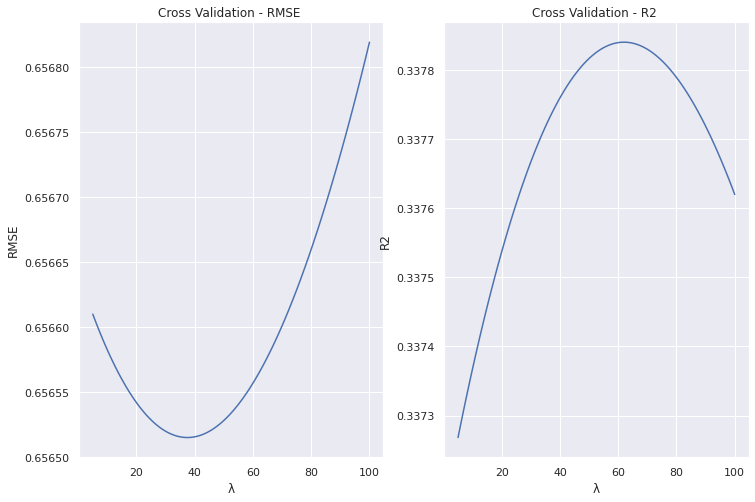

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(lambdas, scores_RMSE, label = 'RMSE')
ax[0].set_title("Cross Validation - RMSE ")
ax[0].set_xlabel('$\mathregular{\lambda}$')
ax[0].set_ylabel('RMSE')

ax[1].plot(lambdas, scores_R2, label = '$\mathregular{R^2}$')
ax[1].set_title("Cross Validation - R2 ")
ax[1].set_xlabel('$\mathregular{\lambda}$')
ax[1].set_ylabel('R2')
plt.show()

In [ ]:
print("RMSE:", min(scores_RMSE),"    R2:", max(scores_R2))

RMSE: 0.6565149650630501     R2: 0.3378405047338583


In [ ]:
print("RMSE:", np.std(scores_RMSE),"    R2:", np.std(scores_R2))

RMSE: 8.443778901794507e-05     R2: 0.0001508711376326988


#4. Teste sem outliers - Vinho Tinto

##4.1 Preprocessamento

In [ ]:
r_wine_cleaned = apply_remotion(r_wine)

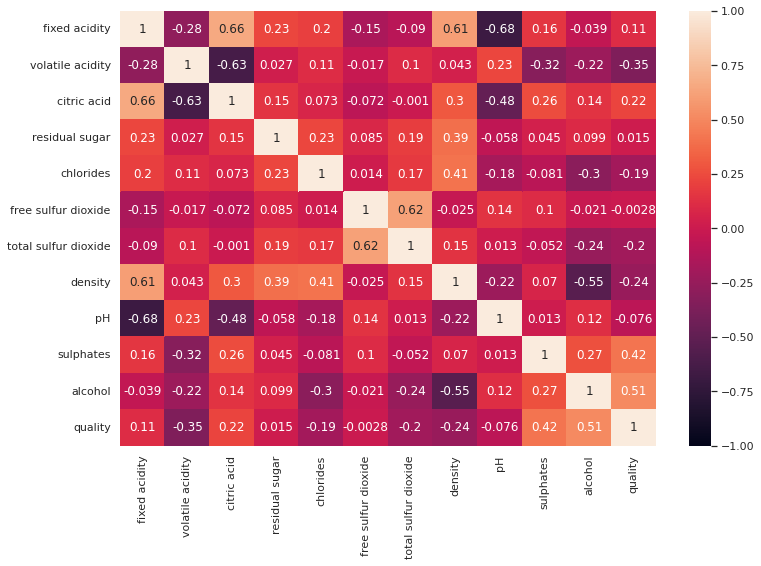

In [ ]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.heatmap(r_wine_cleaned.corr(), annot=True, vmin=-1, vmax=1)
plt.savefig('r_wine_heatmap.png')

In [ ]:
X = r_wine_cleaned.iloc[:, 0:11]
y = r_wine_cleaned.iloc[:, -1]
column_name = r_wine_cleaned.drop(columns=['quality']).columns

# In general, it's a good idea to scale the data prior to PCA.
scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)    
pca = PCA()
x_new = pca.fit_transform(X)

def myplot(pcs,loadings, target, column_name, labels=None):
    xs = pcs[:,0]
    ys = pcs[:,1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    pc1 = xs*scalex
    pc2 = ys*scaley

    df = {'pc1': pc1, 'pc2': pc2, 'quality': target}
    df = pd.DataFrame(data=df)

    fig = px.scatter(df, x='pc1', y='pc2', color='quality', color_continuous_scale = "rainbow")

    for i, feature in enumerate(column_name):
        fig.add_shape(type='line',
                      x0=0,
                      y0=0,
                      x1=loadings[i,0],
                      y1=loadings[i,1]
                    )
        fig.add_annotation(x=loadings[i,0],
                           y=loadings[i,1],
                           ax=0,
                           ay=0,
                           xanchor="center",
                           yanchor="bottom",
                           text = feature,
                           font=dict(size=18,
                                     color="crimson"
                                    )
                          )
    fig.show()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]), y, column_name)

In [ ]:
r_wine_cleaned.drop(columns=["free sulfur dioxide", "citric acid", "density", "pH"], inplace = True)

##4.2 Teste com modelos de regressão

### 4.2.1 Regressão Linear

**Importando bibliotecas**

In [ ]:
import sklearn.model_selection as skms
import sklearn.linear_model as sklm
import sklearn as sk

**Definindo o x e y**

In [ ]:
df = pd.DataFrame.from_dict(r_wine_cleaned)
r_wine_train = df.copy(deep=False)
del r_wine_train['quality']
y = pd.concat([r_wine_cleaned['quality']], axis = 1)

**Fazendo a regressão linear**

In [ ]:
x_treino, x_teste, y_treino, y_teste = skms.train_test_split(r_wine_train, y, test_size=0.25, random_state=0)
lm = sklm.LinearRegression()
lm.fit(x_treino, y_treino)
f = lm.predict(r_wine_train)
y_pred = lm.predict(x_teste)

In [ ]:
print(lm.coef_)
print(lm.intercept_)

[[ 2.59194677e-02 -8.83284705e-01 -5.61171658e-02 -1.90592109e+00
  -1.56920479e-03  1.56279156e+00  2.81964745e-01]]
[2.32142987]


#### Cross-validation - Vinho Branco

**RMSE 5-fold Cross validation**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits = 5, random_state = None)
media = cross_val_score(lm, r_wine_train, y, cv=kf, scoring = 'neg_mean_squared_error')
print(-media)

[0.35189146 0.35813366 0.34565469 0.3817568  0.41483005]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

-0.3704533327247534
-------------
0.025331210489802754


**RMSE 10-fold Cross validation**

In [ ]:
kf = KFold(n_splits = 10, random_state = None)
media = cross_val_score(lm, r_wine_train, y, cv=kf, scoring = 'neg_mean_squared_error')
print(-media)

[0.3552137  0.35584215 0.40562862 0.31145273 0.30003122 0.40076132
 0.43451837 0.33532937 0.32966387 0.49577566]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

-0.37242170060299373
-------------
0.05806091059077696


**$R^2$ 5-Fold validation**

In [ ]:
kf = KFold(n_splits = 5, random_state = None)
media = cross_val_score(lm, r_wine_train, y, cv=kf, scoring = 'r2')
print(media)

[0.24428934 0.39530142 0.44401493 0.34432828 0.25586239]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

0.3367592728334418
-------------
0.07756705780924623


**$R^2$ 10-Fold validation**

In [ ]:
kf = KFold(n_splits = 10, random_state = None)
media = cross_val_score(lm, r_wine_train, y, cv=kf, scoring = 'r2')
print(media)

[0.09291058 0.32399381 0.38482864 0.24228428 0.37518498 0.42231464
 0.23353082 0.38995385 0.31768925 0.21486479]


In [ ]:
print(media.mean())
print("-------------")
print(media.std())

0.2997555624984807
-------------
0.09729982026123757


### 4.2.2 Regressão $L_2$-penalizada/Ridge

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
# dividindo os dados entre conjunto de teste e treino
# definindo o cojunto de dados X para a regressão
df = pd.DataFrame.from_dict(r_wine_cleaned)
r_wine_train = df.copy(deep=False)
del r_wine_train['quality']
y = pd.concat([r_wine_cleaned['quality']], axis = 1) # definindo a variável independente

x_treino, x_teste, y_treino, y_teste = skms.train_test_split(r_wine_train, y, test_size=0.25, random_state=0)

# centralizando e scaling dos dados
x_treino = StandardScaler().fit_transform(x_treino)
x_teste = StandardScaler().fit_transform(x_teste)

# definindo espaço de busca para os lambdas
lambdas = np.linspace(5, 100, 100)

In [ ]:
scores_RMSE = []
scores_R2 = []

for lamb in lambdas:
    # aplicando a regressão
    ridge = sklm.Ridge(alpha = lamb)
    ridge.fit(x_treino, y_treino)             # Fit a ridge regression on the training data
    
    scores = skms.cross_validate(ridge, x_treino, y_treino, cv=10, scoring=('r2', 'neg_root_mean_squared_error'))
    
    scores_RMSE.append(np.mean(scores['test_neg_root_mean_squared_error']*(-1)))
    scores_R2.append(np.mean(scores['test_r2']))

In [ ]:
ridge_best_w = sklm.Ridge(alpha = 0.25)
ridge_best_w.fit(x_treino, y_treino)             # Fit a ridge regression on the training data
pred_w = ridge_best_w.predict(x_teste)           # Use this model to predict the test data
print("RMSE :\n", mean_squared_error(y_teste, pred_w, squared=False))          # Calculate the test MSE
print("R2 :\n", r2_score(y_teste, pred_w))          # Calculate the test R2

RMSE :
 0.5541381561904799
R2 :
 0.4566916508754538


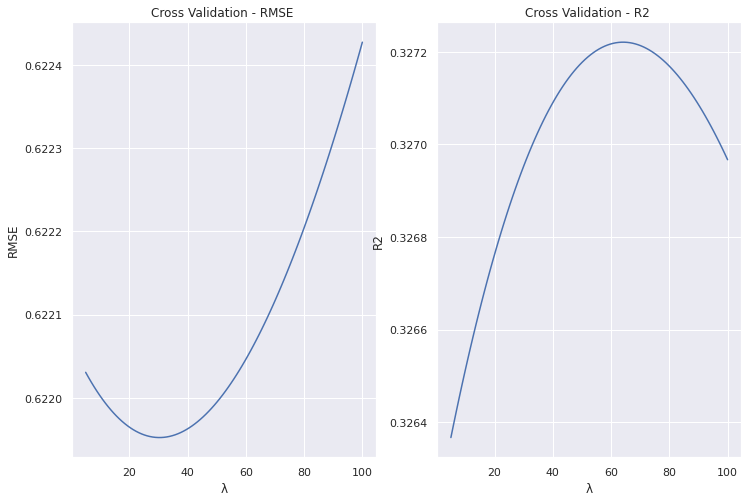

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(lambdas, scores_RMSE, label = 'RMSE')
ax[0].set_title("Cross Validation - RMSE ")
ax[0].set_xlabel('$\mathregular{\lambda}$')
ax[0].set_ylabel('RMSE')

ax[1].plot(lambdas, scores_R2, label = '$\mathregular{R^2}$')
ax[1].set_title("Cross Validation - R2 ")
ax[1].set_xlabel('$\mathregular{\lambda}$')
ax[1].set_ylabel('R2')
plt.show()

In [ ]:
print("RMSE:", min(scores_RMSE),"    R2:", max(scores_R2))

RMSE: 0.62195232155946     R2: 0.3272209282332377


In [ ]:
print("RMSE:", np.std(scores_RMSE),"    R2:", np.std(scores_R2))

RMSE: 0.0001389248570336367     R2: 0.0002274583050406255


# Vinho tinto - Comparação

<table>
  <thead>
    <tr>
      <th scope="col">Método</th>
      <th scope="col" colspan="2">Com outliers</th>
      <th scope="col" colspan="2">Sem outliers</th>
      <th scope="col">Direrença entre médias
    </tr>
  </thead>
  <tbody>
    <tr>
      <th scope="row">#</th>
      <td><strong>Média</strong></td>
      <td><strong>Desvio Padrão</strong></td>
      <td><strong>Média</strong></td>
      <td><strong>Desvio Padrão<strong></td>
      <td><strong>#<strong></td>
    </tr>
    <tr>
      <th scope="row">Regressão Linear (RMSE 5-Fold)</th>
      <td>0.434</td>
      <td>0.013</td>
      <td>0.370</td>
      <td>0.025</td>
      <td>-17.3%</td>
    </tr>
    <tr>
      <th scope="row">Regressão Linear (RMSE 10-Fold)</th>
      <td>0.433</td>
      <td>0.051</td>
      <td>0.372</td>
      <td>0.058</td>
      <td>-16.4%</td>
    </tr>
    <tr>
      <th scope="row">Regressão Linear (R2 5-Fold)</th>
      <td>0.295</td>
      <td>0.080</td>
      <td>0.337</td>
      <td>0.078</td>
      <td>12.5%</td>
    </tr>
    <tr>
      <th scope="row">Regressão Linear (R2 10-Fold)</th>
      <td>0.240</td>
      <td>0.2</td>
      <td>0.3</td>
      <td>0.097</td>
      <td>20%</td>
    </tr>
    <tr>
      <th scope="row">Regressão L2 (RMSE)</th>
      <td>0.657</td>
      <td>0</td>
      <td>0.622</td>
      <td>0</td>
      <td>-5.63%</td>
    </tr>
    <tr>
      <th scope="row">Regressão L2 (R2)</th>
      <td>0.338</td>
      <td>0</td>
      <td>0.327</td>
      <td>0</td>
      <td>-3.4%</td>
    </tr>
    
  </tbody>
</table>